## <center>  CS/ECE/ISyE 524 &mdash; Introduction to Optimization &mdash; Spring 2018 </center>

# <center> Optimizing Multi-core CPU Scheduling </center>

#### <center> Haoran Qiu (hqiu35@wisc.edu), Jian Wu (jwu384@wisc.edu), Tao Ji (tji24@wisc.edu), Yanting Liang (yliang73@wisc.edu) </center>
#### <center> Instructor: Prof. Laurent Lessard </center>
#### <center> May 7<sup>th</sup>, 2018 </center>

*****

### Table of Contents

1. [Introduction](#1.-Introduction)
  1. [Problem Description](#1.1.-Problem-Description)
  2. [Goals and Objectives](#1.2.-Goals-and-Objectives)
  3. [Report Outline](#1.3.-Report-Outline)
2. [Mathematical Model](#2.-Mathematical-Model)
  1. [Concepts & Terminologies](#2.1.-Concepts-&-Terminologies)
  2. [Metric for Objectives](#2.2.-Metric-for-Objectives)
  3. [Perfect Information](#2.3.-Perfect-Information)
    1. [Knowing Arrival Time & Duration](#2.3.1.-Knowing-Arrival-Time-&-Duration)
    2. [Multicores](#2.3.2.-Multicores)
    3. [Process Dependency](#2.3.3.-Process-Dependency)
  4. [Robust Integer Programming](#2.4.-Robust-Programming)
    1. [Unknown Duration](#2.4.1.-Unknown-Duration)
    2. [Unknown Duration & Unknown Arrival Time](#2.4.2.-Unknown-Duration-&-Unknown-Arrival-Time)
  5. [Stochastic Programming](#2.5.-Stochastic-Programming)
    1. [Unknown Duration](#2.5.1.-Unknown-Duration)
    2. [Unknown Duration & Unknown Arrival Time](#2.5.2.-Unknown-Duration-&-Unknown-Arrival-Time)
3. [Solution](#3.-Solution)
  1. [Perfect Information](#3.1.-Perfect-Information)
    1. [Knowing Arrival Time & Duration](#3.1.1.-Knowing-Arrival-Time-&-Duration)
    2. [Multicores](#3.1.2.-Multicores)
    3. [Process Dependency](#3.1.3.-Process-Dependency)
  2. [Robust Integer Programming](#3.2.-Robust-Programming)
    1. [Unknown Duration](#3.2.1.-Unknown-Duration)
    2. [Unknown Duration & Unknown Arrival Time](#3.2.2.-Unknown-Duration-&-Unknown-Arrival-Time)
  3. [Stochastic Programming](#3.3.-Stochastic-Programming)
    1. [Unknown Duration](#3.3.1.-Unknown-Duration)
    2. [Unknown Duration & Unknown Arrival Time](#3.3.2.-Unknown-Duration-&-Unknown-Arrival-Time) 
4. [Results and Discussion](#4.-Results-And-Discussion)
  1. [Result Visualization](#4.1.-Result-Visualization)
    1. [Perfect Information - Single Core](#4.1.1.-Perfect-Information---Single-Core)
    2. [Perfect Information - Multicores](#4.1.2.-Perfect-Information---Multicores)
    3. [Perfect Information - Process Dependency](#4.1.3.-Perfect-Information---Process-Dependency)
  2. [Comparison With Standalone Schedduling Algorithms](#4.2.-Comparison-With-Standalone-Schedduling-Algorithms)
  3. [Sensitivity Analysis](#4.3.-Sensitivity-Analysis)
5. [Conclusion](#5.-Conclusion)
6. [References](#6.-References)
7. [Bonus! Have Fun Here!](#7.-Bonus!-Have-Fun-Here!)

*****

#### Note: ####
- **Interactive design**: In solution part, readers can choose whether they want to make their CPU scheduler to emphasize fairness, efficiency, or responsiveness by adjusting weight to corresponding metrics(Bonus comes at the end of this report, have fun!).
- **Latex rendering**: Please open our project in Jupyter Notebook instead of viewing it in nbviewer due to some Latex rendering issues.

## 1. Introduction ##

### 1.1. Problem Description ###

Sitting in front of your personal computer, perhaps you are playing a video game, browsing a website, and having a chat with your friends via WeChat at the same time. How could it be possible to open so many applications on a computer and run them at the same time? Who is in charge here? The answer is the operating system.

<img src="operating_system.jpg" width="450" height="400" />
###### <center>Fig. 1: Operating system makes it possible to run multiple applications at the same time</center> ######

The **Operating System**(OS) is a really important piece of software present in virtually all computer systems, which manages computer hardware and softwares and provides common resources for computer programs. A computer program is a piece of code but it lives as a process when it is being executed. One of the duties of an operating system is to schedule processes to run on the computer. In 1950s, process scheduling was not an issue because there is not so much process so that the OS can serve all users/processes one by one. When it came to 1960s - early 1980s, multiprogramming and time-sharing evolves([history](https://en.wikipedia.org/wiki/Timeline_of_operating_systems)). Process scheduling should handle multiple processes, swap job to avoid idleness. There will be many processes that want to be executed. Time-sharing OS allows many users/processes to share the computing resources such as main memory, input/output(I/O) devices, files, etc.

The OS has many components which work together to help carry out resource management duties. For example there is a memory manager(manages the usage of the main memory), various device drivers(carry out low-level interactions with hardware devices), I/O manager(handles data transfer between memory and I/O devices), process manager(creates and destroys processes), file system manager(manages the file system), etc. Another important component is the process scheduler, also known as the **Central Processing Unit**(CPU), which is the focus of this project.

<!--![A shot of processes running on a multicore CPU and the resource usage](cpu_scheduling.png =100x20)-->
<img src="cpu_scheduling.png" width="540" height="270" />
###### <center>Fig. 2: A shot of processes running on a 4-core CPU and the resource usage</center> ######

The job of the scheduler is to assign tasks to CPUs, i.e. what is the next process to be run on which CPU. For a computer, there could be multiple CPUs and each CPU could have multiple cores. For a process, it could generate a number of threads to be executed at the same time. Since every core in a CPU could run its assigned task at the same time, we could seen a core as the most basic execution unit. In addition, since a thread is similar as a process(and in some OS they are treat nearly the same way) we could seen a thread as a process. Therefore, the number of processes that can be run at the same time($X$) can be expressed by the multiplication of the number of CPUs($C$) and the number of cores per CPU($c_{i}$):

$$
X = \sum_{i=1}^{C} c_i
$$

However, things are really complicated in reality. There can be mainly two kinds of processes, one is called CPU-bound process and the other is called I/O-bound process, which should be treated differently. There may also be dependencies or conflicts among different processes. A process cannot continue running without another process returning a result, or two processes are using the same resource so that they cannot be scheduled to run at the same time. In addition, scheduling among multicores brings more cost caused by **context switch**. When the ongoing process is being replaced by another process before it is done, its state information should be stored to somewhere else(main memory or hard disk) and the new process' state information(if exists) should be moved to CPU. This process is called context switch. Switching between different cores leads to more cost. Last but not least, a CPU cannot predict when a process will finish its execution and it is not possible for a CPU to know when a particular process will arrive.

Considering all the complexities, we will present a general model in this report to solve this problem and offer an efficient solution for scheduling processes in multicore CPU.

### 1.2. Goals and Objectives ###

How the CPU, the bottleneck device in the whole computer, is scheduled, has a huge impact on the performance of the computer system. To make better decisions, the following objectives have to be met:

- Minimize the total turnaround time: turnaround time is the period of time between the arrival of a process and the time it is finished, which should be as small as possible;
- Maximize the number of processes that can be completed in a certain period of time, i.e. maximize the throughput.
- Be fair to every process: there should not be any process being wait for a long time without being executed;
- Be as responsive as possible: a process should be treated soon after its arrival;

### 1.3. Report Outline ###

First of all, several key terminologies will be introduced in section 2.1., followed by a section introducing the metric we used in our models to measure the objectives. This report will divide the whole problem into multiple stages, progressively solving more complex versions of this problem. Starting with something simple that we know the arrival time and the duraiton of each process(model 2.3.1.), then comes multicores(model 2.3.2.), then we deal with process dependencies(model 2.3.3.). After talking about models under perfect information, we will use two different models: robust programming(model 2.4.) and stochastic programming(model 2.5.) to deal with uncertainty in arrival time and duraiton of processes.

After presenting the models, we will give our solutions to each of the models and discuss about the result of the solutions. Different test cases and data can be come up with or drawn from the internet. Comparisons between our scheduling optimization and extant scheduling algorithms will also be made in the discussion section. Lastly, sensitivity analysis will be carried out to show different compact of each objective.

[shot]: https://github.com/tony-wj/Julia_hw/blob/master/cpu_scheduling.png

## 2. Mathematical Model ##

### 2.1. Concepts & Terminologies ###

Before we talking about the mathematical models, here are several terms and concepts the reader need to know:

- **CPU-bound(compute-bound) process**: when running, tends to use all the processor time that allocated to it;
- **I/O-bound process**: tends to use the processor only briefly before generating I/O request and relinquishes the processor;
    - Usually interactive, i.e. it is real-time and need **immediate reaction** from the OS, e.g. pressing a key on the keyboard
- **Process vs Thread**: they are both independent sequences of execution and the typical difference is that threads(of the same process) run in a shared memory space, while processes run in separate memory spaces;
- **Turnaround time**: the amount of time to execute a particular process(from submission to complete servicing);
    - $T_{turnaround}=T_{completion}-T_{arrival}$
- **Waiting time**: the amount of time a process was waiting in the ready queue(not being served);
- **Response time**: the amount of time it takes from when a process(job) is submitted to the first time it is scheduled(arrived but not getting served yet);
    - An important performance metric of interactive tasks
- **Throughput**: average number of processes that complete their execution per time unit;
- **Fairness**: all similar processes are treated the same, and even if processes are in different priority classes, no process should suffer indefinite postponement(starvation) due to scheduling;
- **Context-switch cost**: a context switch is the process of storing the state of a process or of a thread, so that it can be restored and execution resumed from the same point later(context-switch from one core to another is more expensive than swiching on the same core);
    - A kind of extra cost that we want to avoid

Although the realistic problem is actually really complicated and thorny, our key insights could help a lot the formulation of the model from the problem.

- All process could be seen as only using the CPU, i.e. no I/O. The reason behind is that jobs with I/O interact with the CPU for a tiny time period and then access the I/O so that they can be treated with each CPU burst(separated by I/O) as an independent job.
- Treat each thread as a process. Because they are both indenpendent execution of programs, both have context switch cost (and in fact in many modern OSs like Linux they are treated the same way).

### 2.2. Metric for Objectives ###

- Turnaround time: Let $A_{i}$, $F_{i}$, and $s_{i}$ be the arrival time, finish time, and duration of the i-th process respectively. Thus the metric for the turnaround time is:
<br><br>
$$Tu(\boldsymbol{X})=\frac{\sum_{i=1}^n (F_{i}-A_{i})}{\sum_{i=1}^n s_{i}}$$
<br>
- Fairness: Let $W_{i}$ be the total amount of waiting time for the i-th process(after the arrival and before complete), then fairness can be measured by the variance:
<br><br>
$$
F(\boldsymbol{X})=\sigma^2\\
\sigma^2 = \frac{\sum_{i=1}^{n}(W_i - \mu)^2} {n}\\
\mu = \frac{\sum_{i=1}^n W_{i}}{n}
$$
<br>
- Responsiveness: Let $E_{i}$ be the time when the process i first being executed, and the metric is:
<br><br>
$$R(\boldsymbol{X})=\sum_{i=1}^n E_i$$
<br>
- Cost: Let $\Psi(p, q, i, j)$ be the context switch cost of switching on core $p$ from process i to process j, and process j' previous state information is stored near core $q$. The cost of each context switch is:
<br><br>
$$
\Psi(p, q, i, j) = \left\{
        \begin{array}{ll}
            0 & i=j \\
            \psi_1 & i\neq j, p = q \\
            \psi_2 & i\neq j, p\neq q 
        \end{array}
    \right.
$$
<br>
The total context switch cost of single-core CPU is:
<br><br>
$$
C_1(\boldsymbol{X})=\sum_{t=2}^m \sum_{i -> j}^{n*n} \Psi(c, c, i, j)
$$
<br>
The total context switch cost of multi-core CPU is(given core set $Co$):
<br><br>
$$
C_2(\boldsymbol{X})=\sum_{t=2}^m \sum_{p, q\in Co} \sum_{i -> j}^{n*n} \Psi(p, q, i, j)
$$
<br>
- Throughput: Let $Th(x)$ be the throughput of in the time interval $[a, b]$, and $\Phi_i$ denote the binary variable whether the process is completed. 
<br><br>
$$
Th(\boldsymbol{X})= \frac{\sum_{i=1}^n \Phi_i}{b-a}
$$

### 2.3. Perfect Information ###
#### 2.3.1. Knowing Arrival Time & Duration ####
We divide the time horizon into a number of time units. We only consider time in $[0, m]$ where $m$ is the maximum possible processing time. Let $\mathcal{T}$ denote the set of time units, and $|\mathcal{T}|=m$. Let $\mathcal{N}$ denote the set of tasks, where $|\mathcal{N}|=n$. Each process $n \in \mathcal{N}$ has following attributes: duration $s_n$, arrival time $t_n$. 

<img src="assignment_graph.png" width="400" height="400" />
<center>Fig. 3: An example of time units assignment</center>

The task scheduler assigns each process to the time units, hence we can formulate an Generalized Assignment Problem(GAP). Let binary decision variable $x_{ij}$ denote the j-th time unit is assigned to i-th process. The i-th process requires $s_i$ amount of time to process, and each time unit is at most associated with one process. We have:

$$
\begin{aligned}
\sum_{j=1}^m x_{ij} = s_i \qquad \forall i \in \mathcal{N}\\
\sum_{i=1}^n x_{ij} \leq 1 \qquad \forall j \in \mathcal{T}
\end{aligned}
$$

Note we can only assign time units after arrival of each process, hence the first constraint should be modified as:

$$
\begin{aligned}
\sum_{j = t_i}^m x_{ij} = s_i \qquad \forall i \in \mathcal{N}\\
\sum_{j = 1}^{t_i} x_{ij} = 0 \qquad \forall i \in \mathcal{N}
\end{aligned}
$$

Each feasible assignment $\mathbf{x}$ is measured by turnaround time $T(\mathbf{x})$, fairness $F(\mathbf{x})$, responsiveness $R(\mathbf{x})$. And cost $C_1(\mathbf{x})$ is included to penalize switch of processed between time units. 

The standard form of the model can be written as: 

$$
\begin{aligned}
\underset{x \in \mathbb{R^{n×m}}}{\text{minimize}}\qquad& Tu(x)+F(x)+R(x)+C_1(x)-Th(x)\\
\text{subject to:}\qquad& \sum_{j = t_i}^m x_{ij} - s_i \leq M \Phi_i - \epsilon(1-\Phi_i) \qquad \forall i \in \mathcal{N}\\
& \sum_{j = t_i}^m x_{ij} - s_i \geq m (1-\Phi_i)+ \epsilon \Phi_i \qquad \forall i \in \mathcal{N}\\
& \sum_{j = 1}^{t_i} x_{ij} = 0 \qquad \forall i \in \mathcal{N}\\
& \sum_{i=1}^n x_{ij} \leq 1 \qquad \forall j \in \mathcal{T}\\
& x_{ij} \in \{0,1\} \qquad \forall i \in \mathcal{N} \quad j \in \mathcal{T}
\end{aligned}
$$


#### 2.3.2. Multicores ####

Let $\mathcal{C}$ denote the set of cores, and $|\mathcal{C}|=c$. Binary decision variable $x_{ijk}$ donote the i-th process is assigned to the j-th time unit of core k. Another cost $C_2(x)$ is imposed if tasks is switched between cores. Now the standard form of the model can be rewritten as: 

$$
\begin{aligned}
\underset{x \in \mathbb{R^{n×m×c}}}{\text{minimize}}\qquad& Tu(x)+F(x)+R(x)+C_1(x)+C_2(x)-Th(x) \\
\text{subject to:}\qquad& \sum_{k = 1}^c \sum_{j = t_i}^m x_{ijk} - s_i \leq M \Phi_i - \epsilon(1-\Phi_i) \qquad \forall i \in \mathcal{N}\\
& \sum_{k = 1}^c \sum_{j = t_i}^m x_{ijk} - s_i \geq m (1-\Phi_i)+ \epsilon \Phi_i \qquad \forall i \in \mathcal{N}\\
& \sum_{j = 1}^{t_i} x_{ijk} = 0 \quad \forall i \in \mathcal{N} \quad k \in \mathcal{C}\\
& \sum_{i=1}^n x_{ijk} \leq 1 \quad \forall j \in \mathcal{T} \quad k \in \mathcal{C}\\
& x_{ijk} \in \{0,1\} \quad \forall i \in \mathcal{N} \quad j \in \mathcal{T} \quad k \in \mathcal{C}
\end{aligned}
$$

#### 2.3.3. Process Dependency ####
If process h is dependent on process g, which means process h should be hanlded strictly after g temporally. 

$$
\begin{align}
 j \cdot x_{hjk} \geq j \cdot x_{gjk}+1 \quad \forall j \in \mathcal{T} \quad k \in \mathcal{C}
\end{align}
$$

### 2.4. Robust Programming ###

In reality, the arrival time of the processes $\bf{t}$ and the time required to complete the processes $\bf{s}$ are random. Hence the scheduler does not have perfect information as discussed in above section. Regarding to the dynamic nature of the problem, we can further propose a robust programming model where these variables are subject to box constraints. This section is organized as following: First we propose a variant of the static model if process duration is unknown, and then we extend the model on the condition of unknow durations and unknown arrivals. 

#### 2.4.1. Unknown Duration ####
If the duration of the process is uncertain and is subject to some distribution. And assume somehow we know the distribution and the duration is subject to a box constraint. Let $\bar{s}$ denote some nominal value of the duration, and $u$ denote the uncertainty. 

$$
\begin{align}
s = \bar{s}+\rho^s \cdot u\\
0 \leq ||u||_{\infty} \leq 1
\end{align}
$$

#### 2.4.2. Unknown Duration & Unknown Arrival Time ####

If both the duration and arrival time of the process are uncertain. Similarly, we assume we know the variables are subject to a box constraint. Let $\bar{t}$ denote the nominal value of arrival time. 

$$
\begin{align}
t = \bar{t}+\rho^t \cdot u\\
0 \leq ||u||_{\infty} \leq 1
\end{align}
$$

### 2.5. Stochastic Programming ###

- Background knowledge for stochastic programming 

Stochastic programming is a framework for modeling optimization problems that involve uncertainty. The goal here is to find some policy that is feasible for all (or almost all) the possible data instances and minimizes the expectation of some function of the decisions and the random variables. The basic formulation of stochastic programming is:

$$
\begin{aligned}
\text{minimize}\qquad& F_0(x) = \textbf{E} f_0(x,w) \\
\text{subject to:}\qquad& F_i(x) = \textbf{E} f_i(x,w) \leq 0 \quad\forall i \in I\\
\end{aligned}
$$

where $x$ are decision variables and $w$ is parameters subject to some distribution.

- Chance constraints

‘chance constraints’ (η is ‘confidence level’):
$$
\begin{aligned}
\textbf{Prob}(f_i(x,w) \leq 0 ) \geq \eta
\end{aligned}
$$

- Finite Set 

Suppose $w \in \{w_1, \dots,  w_N \}$ with $\pi_j = \textbf{Prob}(w = w_j)$ 

$$
\begin{aligned}
\text{minimize}\qquad& F_0(x) = \sum_j^{N} \pi_j f_0(x,w_j) \\
\text{subject to:}\qquad& F_i(x) = \sum_j^{N} \pi_j f_i(x,w_j) \leq 0 \quad\forall i \in I\\
\end{aligned}
$$
#### 2.5.1. Unknown Duration ####

$$s_i = \bar{s_i}$$

#### 2.5.2. Unknown Duration & Unknown Arrival Time ####

$$s_i = \bar{s_i}$$
$$t_i = \bar{t_i}$$

## 3. Solution ##

### 3.1. Perfect Information

#### 3.1.1. Knowing Arrival Time & Duration ####

In [210]:
# Perfect knowledge on single core 
using JuMP, Gurobi

function model1(num_tasks, A, D, max_time, psi_1, lambda_1, lambda_2, lambda_3)
    
    ε = 0.0001

    m = Model(solver=GurobiSolver(OutputFlag=0))

    @variable(m, x[1:num_tasks, 1:max_time], Bin)  # x[i, j] == 1 <=> task i gets executed at time j

    @variable(m, W[1:num_tasks] >= 0, Int)         # Waiting time of each task

    @variable(m, 1 <= E[1:num_tasks] <= max_time, Int)   # Start time of each task
    @variable(m, E_y[1:num_tasks, 1:max_time] >= 0, Int) # Assistant variable of start time
    @variable(m, E_z[1:num_tasks, 1:max_time], Bin)      # Assistant variable of start time

    @variable(m, F[1:num_tasks] <= max_time+2, Int)      # Start time of each task
    @variable(m, F_y[1:num_tasks, 1:max_time] >= 0, Int) # Assistant variable of start time
    @variable(m, F_z[1:num_tasks, 1:max_time], Bin)      # Assistant variable of start time

    @variable(m, Psi_y[1:num_tasks, 1:max_time-1], Int)  # Assistant variable for context switch
    @variable(m, Psi[1:num_tasks, 1:max_time-1], Bin)

    # General Constraints
    for i = 1:num_tasks
        for j = 1:(A[i]-1)
            @constraint(m, x[i,j] == 0)            # A task should not be worked on before it arrives
        end

        @constraint(m, sum(x[i,:]) == D[i])        # Total time quantums occupied by the task should be equal to its length

        for j = A[i]:max_time
            @constraint(m, F[i] >= j*x[i, j] + 1)  # Finish time is the last 1 of each task
        end

    end

    for j = 1:max_time
        @constraint(m, sum(x[:,j]) <= 1)           # Each time quantum should be occupied by at most 1 task
    end

    # Expressing W
    for i = 1:num_tasks
        @constraint(m, W[i] == F[i] - D[i] - A[i]) # Waiting time
    end

    # Expressing E
    for i = 1:num_tasks 
        for j = 1:max_time
            @constraint(m, E_y[i, j] == sum(x[i,1:j]))
        end

        @constraint(m, E_y[i,:] - 1 .<= max_time*E_z[i,:] - ε*(1-E_z[i,:])) # aTx − b ≤ Mz − ε(1−z)
        @constraint(m, E_y[i,:] .>= ε*E_z[i,:])                             # aTx −b ≥ m(1−z) + εz
        @constraint(m, E[i] == sum(1-E_z[i,:])+1)
    end

    # Expressing F
    for i = 1:num_tasks
        @constraint(m, F[i] >= A[i] + D[i])
        for j = 1:max_time
            @constraint(m, F_y[i, j] == sum(x[i,j:max_time]))
        end

        @constraint(m, F_y[i,:] - 1 .<= (max_time+2)*F_z[i,:] - ε*(1-F_z[i,:])) # aTx − b ≤ Mz − ε(1−z)
        @constraint(m, F_y[i,:] .>= ε*F_z[i,:])                                 # aTx −b ≥ m(1−z) + εz
        @constraint(m, F[i] == sum(F_z[i,:])+1)
    end

    # Expressing Psi
    for i = 1 : max_time-1
        @constraint(m, Psi_y[:,i] .== x[:,i+1] .- x[:,i])
    end

    for i = 1:max_time-1
        for j = 1:num_tasks
            @constraint(m, Psi[j,i] >= Psi_y[j,i])
        end
    end

    @expression(m, Tu_x, sum(F-A)/num_tasks)
    @expression(m, mu, sum(W)/num_tasks)
    @expression(m, F_x, sum((W-mu).^2)/num_tasks)
    @expression(m, R_x, sum(E-A)/num_tasks)
    @expression(m, C1_x, sum(Psi))

    @objective(m, Min, Tu_x + lambda_1*F_x + lambda_2*R_x + lambda_3*C1_x)

    status = solve(m)
    return (status, getvalue(x), getvalue(Tu_x), getvalue(F_x), getvalue(R_x), getvalue(C1_x), getvalue(E), getvalue(W), getvalue(F))
end

# Visualize the model output

using PyPlot

function plot_schedule_1(x, A)
    figure(figsize=(max_time, num_tasks))
    xlim([0.5, max_time+1])
    ylim([0, num_tasks+1])
    xlabel("time axis") 
    ylabel("tasks")
    title("CPU Process Schedule - Single Core")

    colors = ["purple", "tomato", "orange", "green", "firebrick"]

    count = 0
    for p in A
        arrow(p, count+2, 0, -1, head_width=0.05, width=0.01, head_length=0.1, overhang=0.5, head_starts_at_zero="true", color=colors[count+1])
        count += 1
    end

    for t in 1 : max_time
        for p in 1 : num_tasks
            if x[p, t] > 0.9
                fill([t, t+1, t+1, t], [p-1, p-1, p, p], color = colors[p]);
            end
        end
    end
end;

#### 3.1.2. Multicores

In [143]:
# Perfect information on multicores
using JuMP, Gurobi

function model2(num_tasks, c, A, D, max_time, psi_1, psi_2, lambda_1, lambda_2, lambda_3, lambda_4)
    ε = 0.0001;    
    
    m = Model(solver=GurobiSolver(OutputFlag=0))

    @variable(m, x[1:num_tasks, 1:max_time, 1:c], Bin)   # x[i, j, k] == 1 <=> task i gets executed at time j by core k

    @variable(m, W[1:num_tasks] >= 0, Int)               # Waiting time of each task

    @variable(m, 1 <= E[1:num_tasks] <= max_time, Int)   # Start time of each task
    @variable(m, E_y[1:num_tasks, 1:max_time] >= 0, Int) # Assistant variable of start time
    @variable(m, E_z[1:num_tasks, 1:max_time], Bin)      # Assistant variable of start time
    @variable(m, E_x[1:num_tasks, 1:max_time], Bin)      # Assistant variable of start time

    @variable(m, F[1:num_tasks] <= max_time+2, Int)      # Finish time of each task
    @variable(m, F_y[1:num_tasks, 1:max_time] >= 0, Int) # Assistant variable of finish time
    @variable(m, F_z[1:num_tasks, 1:max_time], Bin)      # Assistant variable of finish time
    @variable(m, F_x[1:num_tasks, 1:max_time], Bin)      # Assistant variable of finish time

    @variable(m, Psi_y[1:num_tasks, 1:max_time-1, 1:c], Int) # Assistant variable for context switch
    @variable(m, Psi[1:num_tasks, 1:max_time-1, 1:c], Bin)   # Psi[i,k] == 1 <=> there is context switch between time i and i+1 at core k

    @variable(m, Phi_x[1:num_tasks, 1:c] >= 0, Int)
    @variable(m, Phi_y[1:num_tasks, 1:c], Bin)

    # General constraints
    for i = 1:num_tasks
        for k = 1:c
            for j = 1:(A[i]-1)
                @constraint(m, x[i,j,k] == 0)               # A task should not be worked on before it arrives
            end
            for j = A[i]:max_time
                @constraint(m, F[i] >= j*x[i,j,k] + 1)      # Finish time is the last 1 of each task
            end
        end
        @constraint(m, sum(x[i,:,:]) == D[i])               # Total time quantums occupied by the task should be equal to its length
    end

    for j = 1:max_time
        for k = 1:c
            @constraint(m, sum(x[:,j,k]) <= 1)              # Each time quantum should be occupied by at most 1 task
        end
    end

    for i = 1:num_tasks
        for j = 1:max_time
            @constraint(m, sum(x[i,j,:]) <= 1)              # Each task can only be executed by at most one core at each time unit
        end
    end

    # Expressing W
    for i = 1:num_tasks
        @constraint(m, W[i] == F[i] - D[i] - A[i])          # Waiting time is the number of zero time slots
    end

    # Expressing E - starting time of each process
    for i = 1:num_tasks
        for j = 1:max_time
            @constraint(m, sum(x[i,j,k] for k in 1:c) == E_x[i,j])
        end
    end
    for i = 1:num_tasks 
        for j = 1:max_time
            @constraint(m, E_y[i, j] == sum(E_x[i,1:j]))
        end

        @constraint(m, E_y[i,:] - 1 .<= max_time*E_z[i,:] - ε*(1-E_z[i,:])) # aTx − b ≤ Mz − ε(1−z)
        @constraint(m, E_y[i,:] .>= ε*E_z[i,:])                             # aTx −b ≥ m(1−z) + εz
        @constraint(m, E[i] == sum(1-E_z[i,:])+1)
    end

    # Expressing F - finish time of each process
    for i = 1:num_tasks
        @constraint(m, F[i] >= A[i] + D[i])
        for j = 1:max_time
            @constraint(m, sum(x[i,j,k] for k in 1:c) == F_x[i,j])
        end
    end
    for i = 1:num_tasks
        for j = 1:max_time
            @constraint(m, F_y[i, j] == sum(F_x[i,j:max_time]))
        end

        @constraint(m, F_y[i,:] - 1 .<= (max_time+2)*F_z[i,:] - ε*(1-F_z[i,:])) # aTx − b ≤ Mz − ε(1−z)
        @constraint(m, F_y[i,:] .>= ε*F_z[i,:])                                 # aTx −b ≥ m(1−z) + εz
        @constraint(m, F[i] == sum(F_z[i,:])+1)
    end

    # Expressing Psi - single core context switch cost
    for k = 1:c
        for i = 1:max_time-1
            @constraint(m, Psi_y[:,i,k] .== x[:,i+1,k] .- x[:,i,k])
            for j = 1:num_tasks
                @constraint(m, Psi[j,i,k] >= Psi_y[j,i,k])
            end
        end
    end

    # Expressing Phi - multi core context switch cost
    for i = 1:num_tasks
        for k = 1:c
            @constraint(m, Phi_x[i,k] == sum(x[i,:,k]))
            @constraint(m, Phi_x[i,k]-1 <= D[i]*Phi_y[i,k]-ε*(1-Phi_y[i,k]))
            @constraint(m, Phi_x[i,k] >= ε*Phi_y[i,k])
        end
    end

    @expression(m, Tu_x, 1sum(F-A)/num_tasks)
    @expression(m, mu, sum(W)/num_tasks)
    @expression(m, F_x, sum((W-mu).^2)/num_tasks)
    @expression(m, R_x, sum(E-A)/num_tasks)
    @expression(m, C1_x, psi_1*sum(Psi))
    @expression(m, C2_x, psi_2*(sum(Phi_y))-num_tasks)
    @objective(m, Min, Tu_x + lambda_1*F_x + lambda_2*R_x + lambda_3*C1_x + lambda_4*C2_x) 
    
    status = solve(m)
    return (status, getvalue(x), getvalue(Tu_x), getvalue(F_x), getvalue(R_x), getvalue(C1_x), getvalue(C2_x), getvalue(E), getvalue(W), getvalue(F))
end;

# Visualization

using PyPlot 

function plot_schedule_2(x, A, D, c)
    figure(figsize=(max_time, c))
    xlim([0.5, maximum(A) + D[length(D)] + 3])
    ylim([0, c])
    xlabel("time axis")
    ylabel("CPU core")
    title("CPU Process Schedule - Multi-Core ")
    colors = ["purple", "tomato", "orange", "green", "firebrick"]
    for k = 1 : c
        count = 0
        for p in A
            arrow(p, c, 0, -1, color=colors[count+1], head_width=0.05, width=0.01, head_length=0.1, overhang=0.5, head_starts_at_zero="true")
            count += 1
        end

        for t in 1 : max_time
            for p in 1 : num_tasks
                if x[p, t, k] > 0.9
                    fill([t, t+1, t+1, t], [k-0.9, k-0.9, k-0.1, k-0.1], color = colors[p]);
                end
            end
        end
    end
end;

#### 3.1.3. Process Dependency ####

In [174]:
# Perfect information on multicores with job dependency
using JuMP, Gurobi

function model3(num_tasks, c, A, D, process_dependency, max_time, psi_1, psi_2, lambda_1, lambda_2, lambda_3, lambda_4)
    ε = 0.0001;    
    
    m = Model(solver=GurobiSolver(OutputFlag=0))

    @variable(m, x[1:num_tasks, 1:max_time, 1:c], Bin)   # x[i, j, k] == 1 <=> task i gets executed at time j by core k

    @variable(m, W[1:num_tasks] >= 0, Int)               # Waiting time of each task

    @variable(m, 1 <= E[1:num_tasks] <= max_time, Int)   # Start time of each task
    @variable(m, E_y[1:num_tasks, 1:max_time] >= 0, Int) # Assistant variable of start time
    @variable(m, E_z[1:num_tasks, 1:max_time], Bin)      # Assistant variable of start time
    @variable(m, E_x[1:num_tasks, 1:max_time], Bin)      # Assistant variable of start time

    @variable(m, F[1:num_tasks] <= max_time+2, Int)      # Finish time of each task
    @variable(m, F_y[1:num_tasks, 1:max_time] >= 0, Int) # Assistant variable of finish time
    @variable(m, F_z[1:num_tasks, 1:max_time], Bin)      # Assistant variable of finish time
    @variable(m, F_x[1:num_tasks, 1:max_time], Bin)      # Assistant variable of finish time

    @variable(m, Psi_y[1:num_tasks, 1:max_time-1, 1:c], Int) # Assistant variable for context switch
    @variable(m, Psi[1:num_tasks, 1:max_time-1, 1:c], Bin)   # Psi[i,k] == 1 <=> there is context switch between time i and i+1 at core k

    @variable(m, Phi_x[1:num_tasks, 1:c] >= 0, Int)
    @variable(m, Phi_y[1:num_tasks, 1:c], Bin)

    # General constraints
    for i = 1:num_tasks
        for k = 1:c
            for j = 1:(A[i]-1)
                @constraint(m, x[i,j,k] == 0)               # A task should not be worked on before it arrives
            end
            for j = A[i]:max_time
                @constraint(m, F[i] >= j*x[i,j,k] + 1)      # Finish time is the last 1 of each task
            end
        end
        @constraint(m, sum(x[i,:,:]) == D[i])               # Total time quantums occupied by the task should be equal to its length
    end

    for j = 1:max_time
        for k = 1:c
            @constraint(m, sum(x[:,j,k]) <= 1)              # Each time quantum should be occupied by at most 1 task
        end
    end

    for i = 1:num_tasks
        for j = 1:max_time
            @constraint(m, sum(x[i,j,:]) <= 1)              # Each task can only be executed by at most one core at each time unit
        end
    end

    # process dependency constraint
    for i = 1 : num_tasks
        for j = 1 : num_tasks
            if process_dependency[i][j] == 1
                @constraint(m, E[i] >= F[j])
            end
        end
    end

    # Expressing W
    for i = 1:num_tasks
        @constraint(m, W[i] == F[i] - D[i] - A[i])          # Waiting time is the number of zero time slots
    end

    # Expressing E - starting time of each process
    for i = 1:num_tasks
        for j = 1:max_time
            @constraint(m, sum(x[i,j,k] for k in 1:c) == E_x[i,j])
        end
    end
    for i = 1:num_tasks 
        for j = 1:max_time
            @constraint(m, E_y[i, j] == sum(E_x[i,1:j]))
        end

        @constraint(m, E_y[i,:] - 1 .<= max_time*E_z[i,:] - ε*(1-E_z[i,:])) # aTx − b ≤ Mz − ε(1−z)
        @constraint(m, E_y[i,:] .>= ε*E_z[i,:])                             # aTx −b ≥ m(1−z) + εz
        @constraint(m, E[i] == sum(1-E_z[i,:])+1)
    end

    # Expressing F - finish time of each process
    for i = 1:num_tasks
        @constraint(m, F[i] >= A[i] + D[i])
        for j = 1:max_time
            @constraint(m, sum(x[i,j,k] for k in 1:c) == F_x[i,j])
        end
    end
    for i = 1:num_tasks
        for j = 1:max_time
            @constraint(m, F_y[i, j] == sum(F_x[i,j:max_time]))
        end

        @constraint(m, F_y[i,:] - 1 .<= (max_time+2)*F_z[i,:] - ε*(1-F_z[i,:])) # aTx − b ≤ Mz − ε(1−z)
        @constraint(m, F_y[i,:] .>= ε*F_z[i,:])                                 # aTx −b ≥ m(1−z) + εz
        @constraint(m, F[i] == sum(F_z[i,:])+1)
    end

    # Expressing Psi - single core context switch cost
    for k = 1:c
        for i = 1:max_time-1
            @constraint(m, Psi_y[:,i,k] .== x[:,i+1,k] .- x[:,i,k])
            for j = 1:num_tasks
                @constraint(m, Psi[j,i,k] >= Psi_y[j,i,k])
            end
        end
    end

    # Expressing Phi - multi core context switch cost
    for i = 1:num_tasks
        for k = 1:c
            @constraint(m, Phi_x[i,k] == sum(x[i,:,k]))
            @constraint(m, Phi_x[i,k]-1 <= D[i]*Phi_y[i,k]-ε*(1-Phi_y[i,k]))
            @constraint(m, Phi_x[i,k] >= ε*Phi_y[i,k])
        end
    end

    @expression(m, Tu_x, 1sum(F-A)/num_tasks)
    @expression(m, mu, sum(W)/num_tasks)
    @expression(m, F_x, sum((W-mu).^2)/num_tasks)
    @expression(m, R_x, sum(E-A)/num_tasks)
    @expression(m, C1_x, psi_1*sum(Psi))
    @expression(m, C2_x, psi_2*(sum(Phi_y))-num_tasks)
    @objective(m, Min, Tu_x + lambda_1*F_x + lambda_2*R_x + lambda_3*C1_x + lambda_4*C2_x) 
    
    status = solve(m)
    return (status, getvalue(x), getvalue(Tu_x), getvalue(F_x), getvalue(R_x), getvalue(C1_x), getvalue(C2_x), getvalue(E), getvalue(W), getvalue(F))
end;

# Visualization

using PyPlot 

function plot_schedule_3(x, A, D, c)
    figure(figsize=(max_time, c))
    xlim([0.5, maximum(A) + D[length(D)] + 4])
    ylim([0, c])
    xlabel("time axis")
    ylabel("CPU core")
    title("CPU Process Schedule - Process Dependency")
    colors = ["purple", "tomato", "orange", "green", "firebrick"]
    for k = 1 : c
        count = 0
        for p in A
            arrow(p, c, 0, -1, color=colors[count+1], head_width=0.05, width=0.01, head_length=0.1, overhang=0.5, head_starts_at_zero="true")
            count += 1
        end

        for t in 1 : max_time
            for p in 1 : num_tasks
                if x[p, t, k] > 0.9
                    fill([t, t+1, t+1, t], [k-0.9, k-0.9, k-0.1, k-0.1], color = colors[p]);
                end
            end
        end
    end
end;

## 4. Results And Discussion ##

### 4.1. Result Visualization ###

#### 4.1.1. Perfect Information - Single Core

Academic license - for non-commercial use only
Turnaround time T(x): 11.8000
Fairness F(x): 1.360

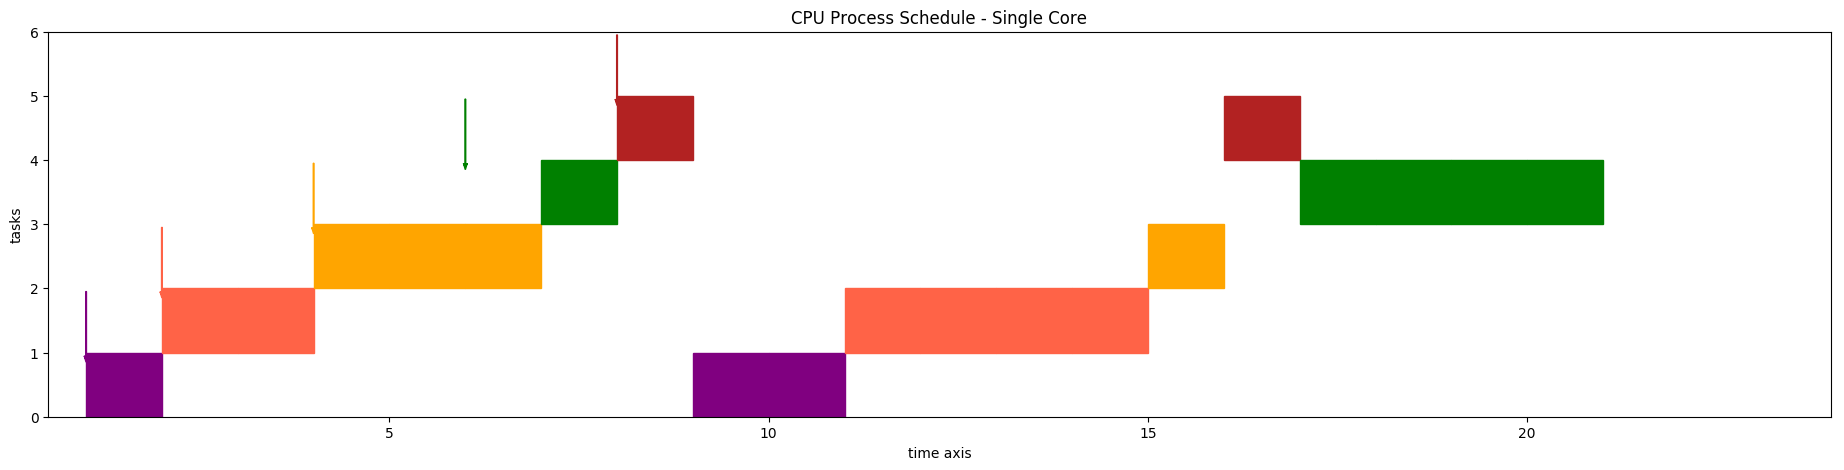

Academic license - for non-commercial use only
Turnaround time T(x): 11.8000
Fairness F(x): 1.3600
Responsiveness R(x): 0.2000
Context switch cost C1(x): 9.0000


In [188]:
# Define input data
num_tasks = 5                      # Number of tasks
A = [1, 2, 4, 6, 8]                # Arrival time of each task
D = [3, 6, 4, 5, 2]                # Duration of each task
max_time = minimum(A) + sum(D) + 2 # Time period considered
psi_1 = 0.4                        # Penalty of context switch
lambda_1 = 1                       # Tradeoff coefficient for fairness F(x)
lambda_2 = 1                       # Tradeoff coefficient for Responsiveness R(x)
lambda_3 = 1                       # Tradeoff coefficient for context switch cost C1(x)

# Run the model
(status, x, Tu, Fa, R, C1, E, W, F) = model1(num_tasks, A, D, max_time, psi_1, lambda_1, lambda_2, lambda_3)

# Plot the result schedule
plot_schedule_1(x, A)

# Print the each part of the objective
@printf("Turnaround time T(x): %.4f\n", Tu)
@printf("Fairness F(x): %.4f\n", Fa)
@printf("Responsiveness R(x): %.4f\n", R)
@printf("Context switch cost C1(x): %.4f\n", C1)

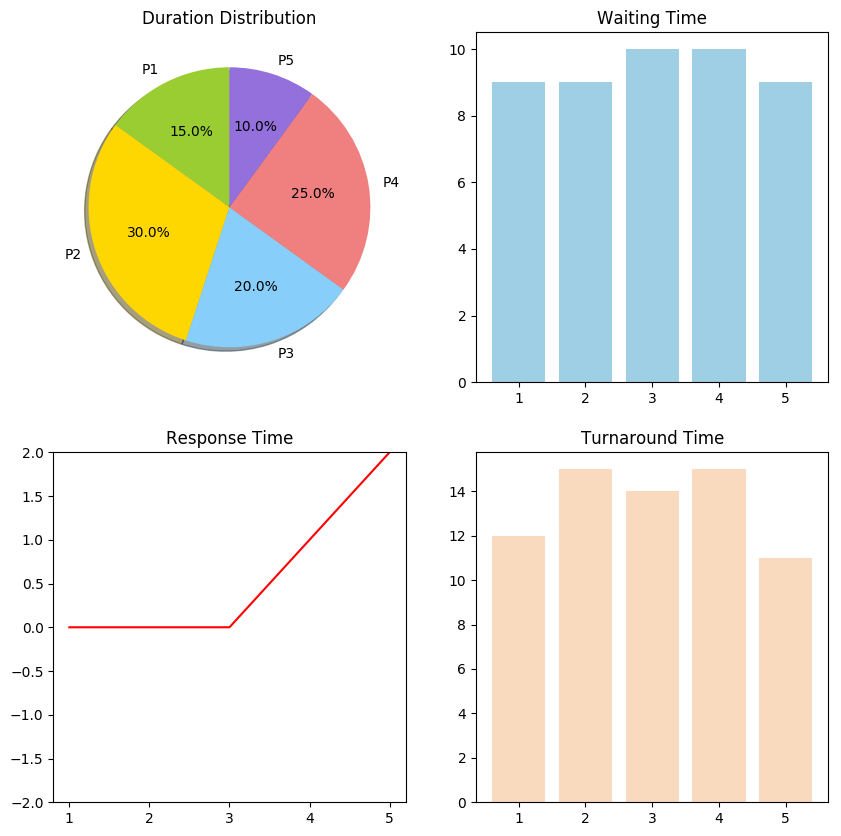

Response time: [2.22045e-12, 0.0, 2.22045e-12, 1.0, 2.0]
Waiting time: [9.0, 9.0, 10.0, 10.0, 9.0]
Turnaround time: [12.0, 15.0, 14.0, 15.0, 11.0]


In [128]:
# waiting time, response time, turnaround time, durations
processes = collect(1:5)

response_time = E - A
waiting_time = W
turnaround_time = F - A

fig = figure(figsize=(10,10)) 
subplot("221")
title("Duration Distribution")
labels = ["P1";"P2";"P3";"P4";"P5"]
colors = ["yellowgreen";"gold";"lightskyblue";"lightcoral";"mediumpurple"]
pie(D, labels=labels, shadow=true, startangle=90, colors=colors, autopct="%.1f%%")

subplot("222")
title("Waiting Time")
bar(processes, waiting_time, color="#0f87bf", align="center", alpha=0.4)

subplot("223")
title("Response Time")
ylim(ymax=2)
ylim(ymin=-2)
plot(processes, response_time, "r-")

subplot("224")
title("Turnaround Time")
bar(processes, turnaround_time, color="sandybrown", align="center", alpha=0.4);

println("Response time: ", response_time);
println("Waiting time: ", waiting_time);
println("Turnaround time: ", turnaround_time);

#### 4.1.2. Perfect Information - Multicores

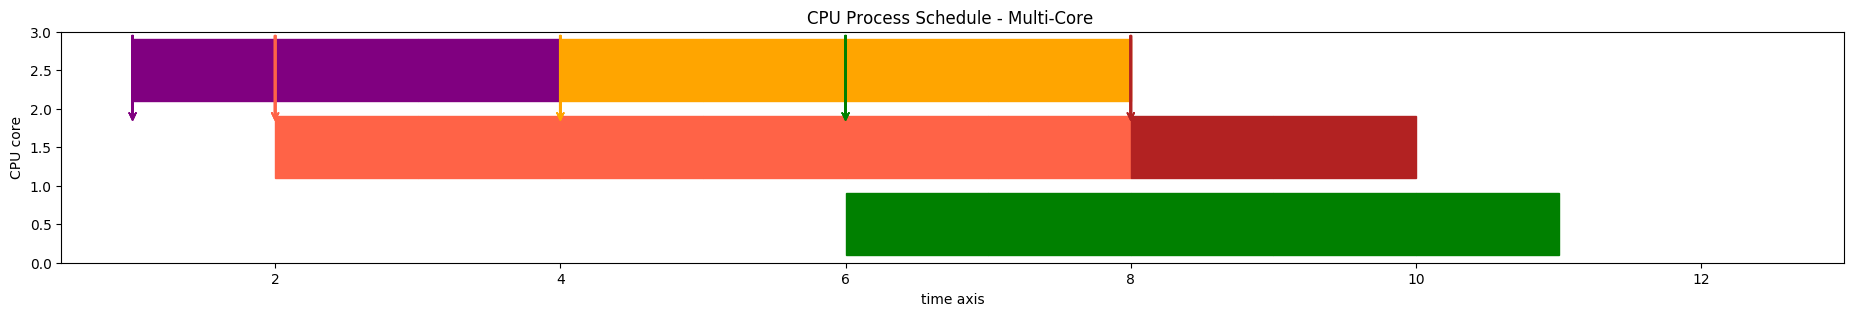

Academic license - for non-commercial use only
Turnaround time T(x): 4.0000
Fairness F(x): 0.0000 (variance of waiting time)
Responsiveness R(x): 0.0000
Context switch cost C1(x)+C2(x): 0.1000


In [146]:
# Define input data
num_tasks = 5                      # Number of tasks
num_cores = 3                      # Number of cores
A = [1, 2, 4, 6, 8]                # Arrival time of each task
D = [3, 6, 4, 5, 2]                # Duration of each task
max_time = minimum(A) + sum(D) + 2 # Time period considered
psi_1 = 0.4                        # Penalty of context switch
psi_2 = 0.7                        # Penalty of context switch between multicores
lambda_1 = 1                       # Tradeoff coefficient for fairness F(x)
lambda_2 = 1                       # Tradeoff coefficient for Responsiveness R(x)
lambda_3 = 1                       # Tradeoff coefficient for context switch cost C1(x)
lambda_4 = 1                       # Tradeoff coefficient for context switch cost C2(x)

# Run the model
(status, x, Tu, Fa, R, C1, C2, E, W, F) = model2(num_tasks, num_cores, A, D, max_time, psi_1, psi_2, lambda_1, lambda_2, lambda_3, lambda_4)

# Plot the result schedule
plot_schedule_2(x, A, D, num_cores)

# Print the each part of the objective
@printf("Turnaround time T(x): %.4f\n", Tu)
@printf("Fairness F(x): %.4f (variance of waiting time)\n", Fa)
@printf("Responsiveness R(x): %.4f\n", R)
@printf("Context switch cost C1(x)+C2(x): %.4f\n", C1+C2)

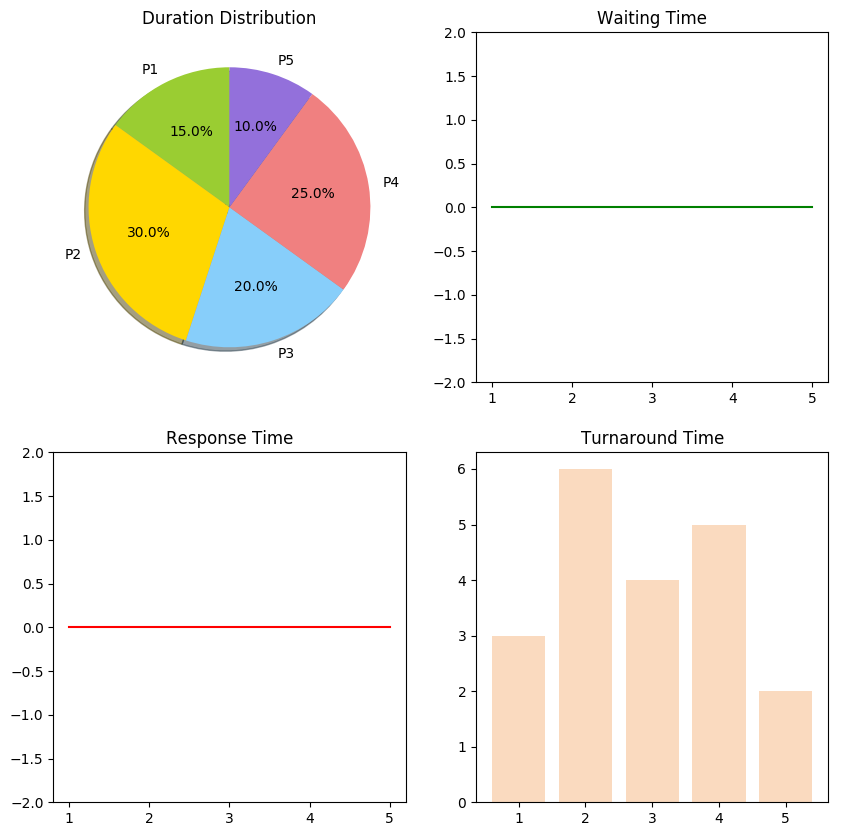

Response time: [0.0, 2.66454e-15, 0.0, 2.66454e-15, 0.0]
Waiting time: [0.0, 0.0, 0.0, 0.0, 0.0]
Turnaround time: [3.0, 6.0, 4.0, 5.0, 2.0]


In [148]:
# waiting time, response time, turnaround time, durations
processes = collect(1:5)

response_time = E - A
waiting_time = W
turnaround_time = F - A

fig = figure(figsize=(10,10)) 
subplot("221")
title("Duration Distribution")
labels = ["P1";"P2";"P3";"P4";"P5"]
colors = ["yellowgreen";"gold";"lightskyblue";"lightcoral";"mediumpurple"]
pie(D, labels=labels, shadow=true, startangle=90, colors=colors, autopct="%.1f%%")

subplot("222")
title("Waiting Time")
# bar(processes, waiting_time, color="#0f87bf", align="center", alpha=0.4)
ylim(ymax=2)
ylim(ymin=-2)
plot(processes, waiting_time, "g-")

subplot("223")
title("Response Time")
ylim(ymax=2)
ylim(ymin=-2)
plot(processes, response_time, "r-")

subplot("224")
title("Turnaround Time")
bar(processes, turnaround_time, color="sandybrown", align="center", alpha=0.4);

println("Response time: ", response_time);
println("Waiting time: ", waiting_time);
println("Turnaround time: ", turnaround_time);

#### 4.1.3. Perfect Information - Process Dependency

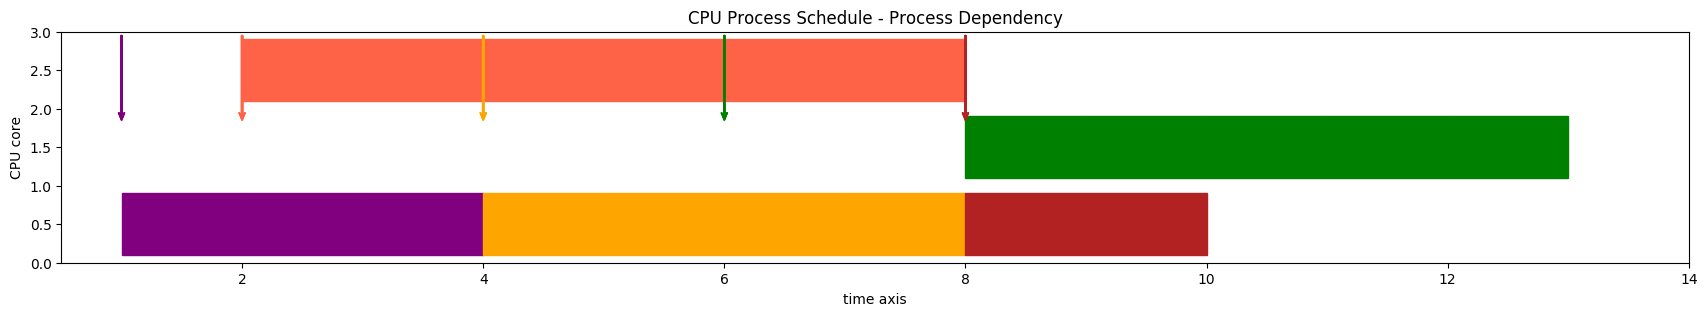

Academic license - for non-commercial use only
Turnaround time T(x): 4.4000
Fairness F(x): 0.6400 (variance of waiting time)
Responsiveness R(x): 0.4000
Context switch cost C1(x)+C2(x): 0.1000


In [175]:
# Define input data
num_tasks = 5                        # Number of tasks
num_cores = 3                        # Number of cores
A = [1, 2, 4, 6, 8]                  # Arrival time of each task
D = [3, 6, 4, 5, 2]                  # Duration of each task
max_time = minimum(A) + sum(D)       # Time period considered
psi_1 = 0.4                        # Penalty of context switch
psi_2 = 0.7                        # Penalty of context switch between multicores
lambda_1 = 1                       # Tradeoff coefficient for fairness F(x)
lambda_2 = 1                       # Tradeoff coefficient for Responsiveness R(x)
lambda_3 = 1                       # Tradeoff coefficient for context switch cost C1(x)
lambda_4 = 1                       # Tradeoff coefficient for context switch cost C2(x)

# process dependency
P = [
    [0,0,0,0,0], [0,0,0,0,0], [1,0,0,0,0], [1,0,1,0,0], [0,1,1,0,0]
]

# Run the model
(status, x, Tu, Fa, R, C1, C2, E, W, F) = model3(num_tasks, num_cores, A, D, P, max_time, psi_1, psi_2, lambda_1, lambda_2, lambda_3, lambda_4)

# Plot the result schedule
plot_schedule_3(x, A, D, num_cores)

# Print the each part of the objective
@printf("Turnaround time T(x): %.4f\n", Tu)
@printf("Fairness F(x): %.4f (variance of waiting time)\n", Fa)
@printf("Responsiveness R(x): %.4f\n", R)
@printf("Context switch cost C1(x)+C2(x): %.4f\n", C1+C2)

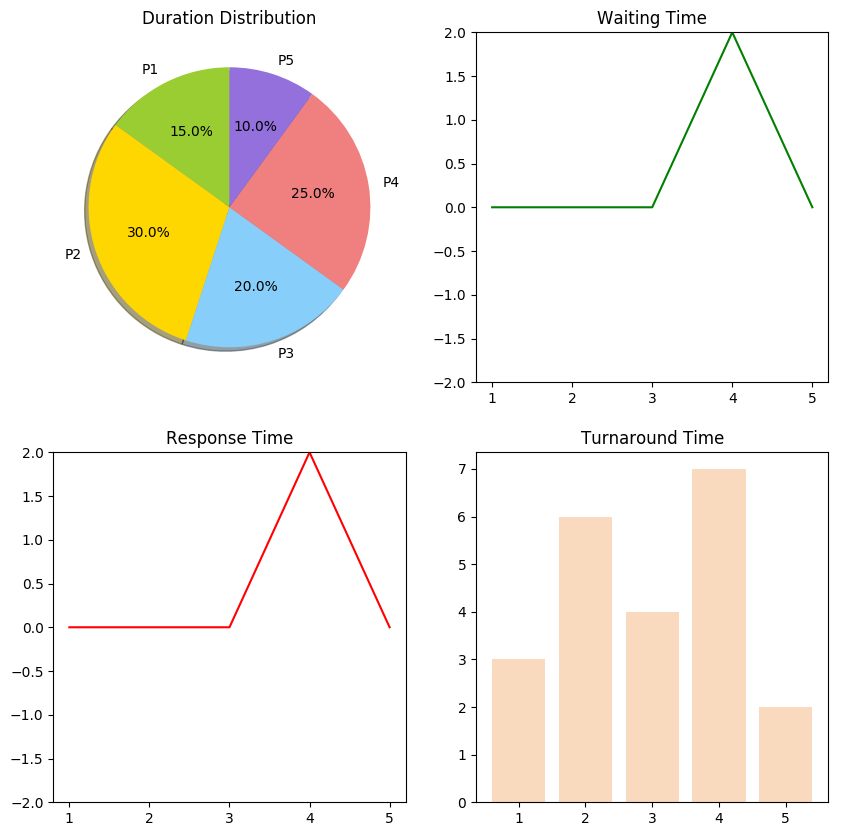

Response time: [0.0, 0.0, 0.0, 2.0, 0.0]
Waiting time: [0.0, 0.0, 0.0, 2.0, 0.0]
Turnaround time: [3.0, 6.0, 4.0, 7.0, 2.0]


In [177]:
# waiting time, response time, turnaround time, durations
processes = collect(1:5)

response_time = E - A
waiting_time = W
turnaround_time = F - A

fig = figure(figsize=(10,10)) 
subplot("221")
title("Duration Distribution")
labels = ["P1";"P2";"P3";"P4";"P5"]
colors = ["yellowgreen";"gold";"lightskyblue";"lightcoral";"mediumpurple"]
pie(D, labels=labels, shadow=true, startangle=90, colors=colors, autopct="%.1f%%")

subplot("222")
title("Waiting Time")
# bar(processes, waiting_time, color="#0f87bf", align="center", alpha=0.4)
ylim(ymax=2)
ylim(ymin=-2)
plot(processes, waiting_time, "g-")

subplot("223")
title("Response Time")
ylim(ymax=2)
ylim(ymin=-2)
plot(processes, response_time, "r-")

subplot("224")
title("Turnaround Time")
bar(processes, turnaround_time, color="sandybrown", align="center", alpha=0.4);

println("Response time: ", response_time);
println("Waiting time: ", waiting_time);
println("Turnaround time: ", turnaround_time);

### 4.2. Comparison to Standalone Scheduling Algorithms ###

Schedule # 1


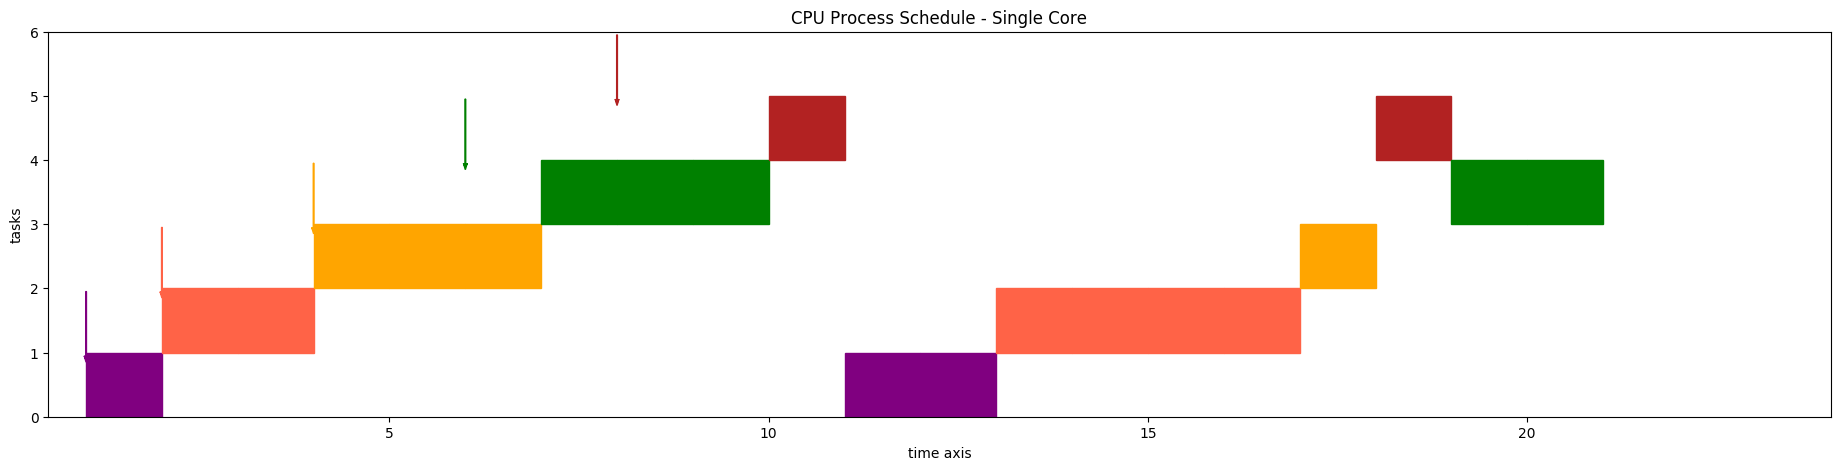

Academic license - for non-commercial use only
Turnaround time T(x): 13.4000
Fairness F(x): 0.2400
Responsiveness R(x): 0.6000
Context switch cost C1(x): 9.0000


In [189]:
# Define input data
num_tasks = 5                      # Number of tasks
A = [1, 2, 4, 6, 8]                # Arrival time of each task
D = [3, 6, 4, 5, 2]                # Duration of each task
max_time = minimum(A) + sum(D) + 2 # Time period considered
psi_1 = 0.4                        # Penalty of context switch

# fairness-driven -> Round Robin Algorithmm
println("Schedule # 1")
lambda_1 = 10                       # Tradeoff coefficient for fairness F(x)
lambda_2 = 1                        # Tradeoff coefficient for Responsiveness R(x)
lambda_3 = 1                        # Tradeoff coefficient for context switch cost C1(x)
(status, x, Tu, Fa, R, C1, E, W, F) = model1(num_tasks, A, D, max_time, psi_1, lambda_1, lambda_2, lambda_3)
plot_schedule_1(x, A)
@printf("Turnaround time T(x): %.4f\n", Tu)
@printf("Fairness F(x): %.4f\n", Fa)
@printf("Responsiveness R(x): %.4f\n", R)
@printf("Context switch cost C1(x): %.4f\n", C1)

#### Round Robin Algorithm ####

Round-robin (RR) is one of the algorithms employed by process and network schedulers in computing. As the term is generally used, time slices (also known as time quanta) are assigned to each process in equal portions and in circular order, handling all processes without priority (also known as cyclic executive). Round-robin scheduling is simple, easy to implement, and starvation-free.

As you can see from the figure above, if fairness is emphasized in our model, the optimal schedule is nearly "round-robin" and waiting time is evenly distributed among processes. In this case, the turnaround time is not optimal. We'll see Shortest Job First case later, which minimizes the turnaround time mainly.

Schedule # 2


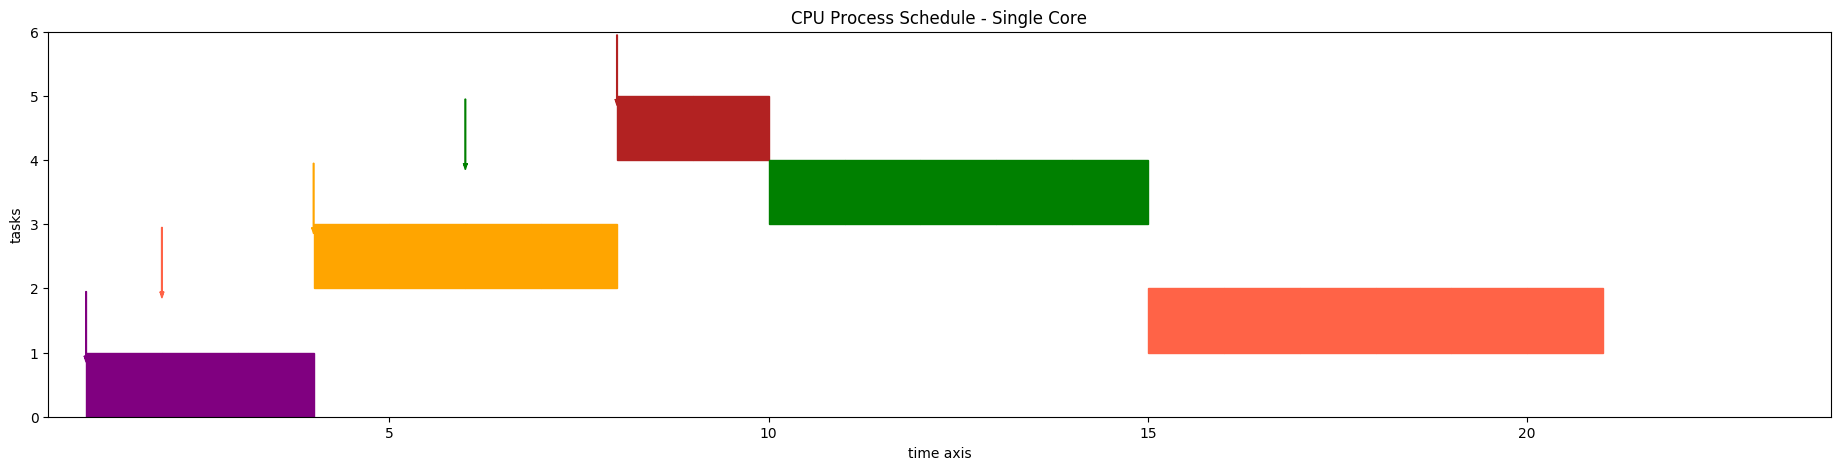

Academic license - for non-commercial use only
Turnaround time T(x): 7.4000
Fairness F(x): 25.4400
Responsiveness R(x): 3.4000
Context switch cost C1(x): 4.0000


In [190]:
# turnaround-time-driven -> Shortest-job-first Algorithm
println("Schedule # 2")
lambda_1 = 0.01                       # Tradeoff coefficient for fairness F(x)
lambda_2 = 0.01                       # Tradeoff coefficient for Responsiveness R(x)
lambda_3 = 0.01                       # Tradeoff coefficient for context switch cost C1(x)
(status, x, Tu, Fa, R, C1, E, W, F) = model1(num_tasks, A, D, max_time, psi_1, lambda_1, lambda_2, lambda_3)
plot_schedule_1(x, A)
@printf("Turnaround time T(x): %.4f\n", Tu)
@printf("Fairness F(x): %.4f\n", Fa)
@printf("Responsiveness R(x): %.4f\n", R)
@printf("Context switch cost C1(x): %.4f\n", C1)

#### Shortest Job First Algorithm ####

Shortest job first is a scheduling algorithm in which the process with the smallest execution time is selected for execution next. Shortest job first can be either preemptive or non-preemptive. Owing to its simple nature, shortest job first is considered optimal. It also reduces the average waiting time for other processes awaiting execution. Total turnaround time is also optimally small.

As you can see from the figure above, the scheduling is consistent with SJF algorithm if turnaround time is emphasized. However, the waiting time is not fairly distributed among processes(F(x) is greatly increased).

Schedule # 3


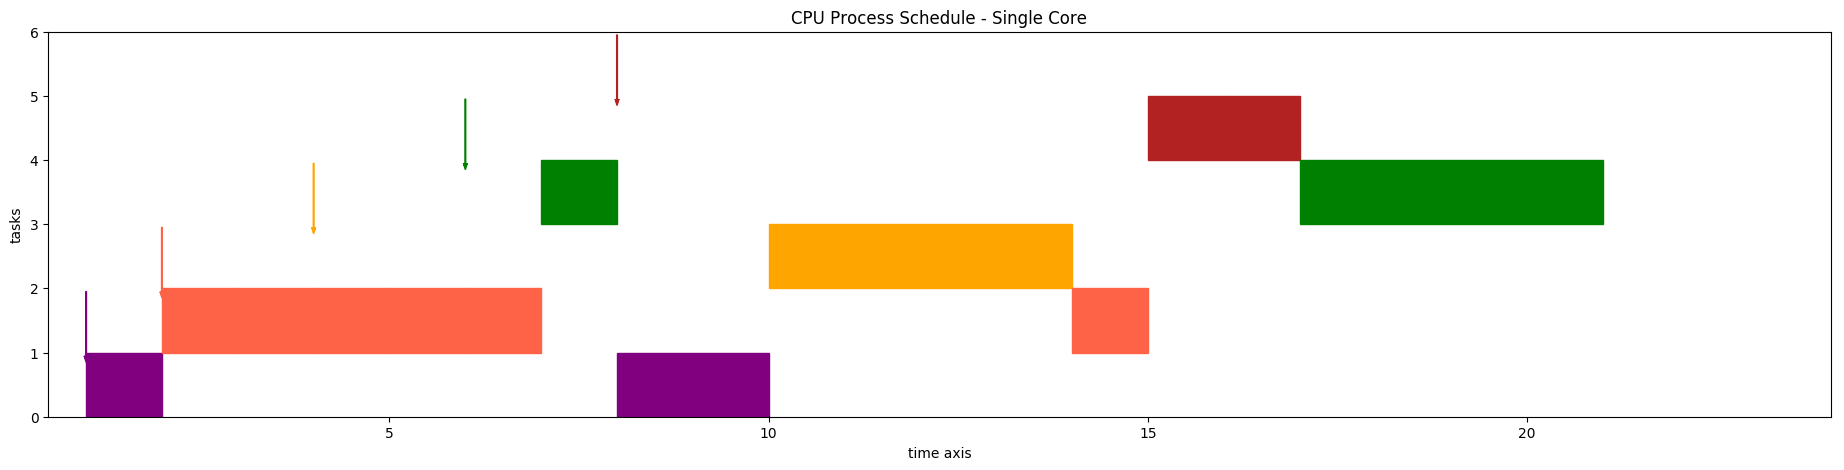

Academic license - for non-commercial use only
Turnaround time T(x): 11.2000
Fairness F(x): 2.1600
Responsiveness R(x): 2.8000
Context switch cost C1(x): 7.0000


In [191]:
# optimal in general
println("Schedule # 3")
lambda_1 = 0.8                       # Tradeoff coefficient for fairness F(x)
lambda_2 = 0.7                       # Tradeoff coefficient for Responsiveness R(x)
lambda_3 = 1                         # Tradeoff coefficient for context switch cost C1(x)
(status, x, Tu, Fa, R, C1, E, W, F) = model1(num_tasks, A, D, max_time, psi_1, lambda_1, lambda_2, lambda_3)
plot_schedule_1(x, A)
@printf("Turnaround time T(x): %.4f\n", Tu)
@printf("Fairness F(x): %.4f\n", Fa)
@printf("Responsiveness R(x): %.4f\n", R)
@printf("Context switch cost C1(x): %.4f\n", C1)

#### Multilevel Feedback Queue Algorithm ####

A multilevel feedback queue is a scheduling algorithm. Solaris 2.6 Time-Sharing (TS) scheduler implements this algorithm. The Mac OS X and Microsoft Windows schedulers can both be regarded as examples of the broader class of multilevel feedback queue schedulers. This scheduling algorithm is intended to meet the following design requirements for multimode systems:

- Give preference to short jobs.
- Give preference to I/O bound processes.
- Separate processes into categories based on their need for the processor.

Compared to other scheduling algorithms, MFQ is general more optimal and used more widly in practice. This improvement is facilitated by the characteristic of the CPU burst of the process. If a process uses too much CPU time, it will be moved to a lower-priority queue. This scheme leaves I/O-bound and interactive processes in the higher priority queues. In addition, a process that waits too long in a lower-priority queue may be moved to a higher priority queue. This form of aging also helps to prevent starvation of certain lower priority processes.

As you can see, in this case, the turnaround time is shorter than the above two scheduling, with generally good fairness, responsiveness and less context switch cost.

### 4.3. Sensitivity Analysis
We perform sensitivity analysis based on the first model, that is, the one with perfect knowledge and based on single core. We could have analyzed the more complicated ones, but there is limitation of computing power. Our PCs take dozens of seconds to solve even the simplest version of the models. Plotting a tradeoff graph requires at least solving the model tens of times. Moreover, the result does not show up if we run the model with 20 iterations. Therefore, what you see is the best we could do.
#### Tradeoff Figures
- **Changing $\lambda_1$, i.e., the coefficient of fairness $F(x)$**

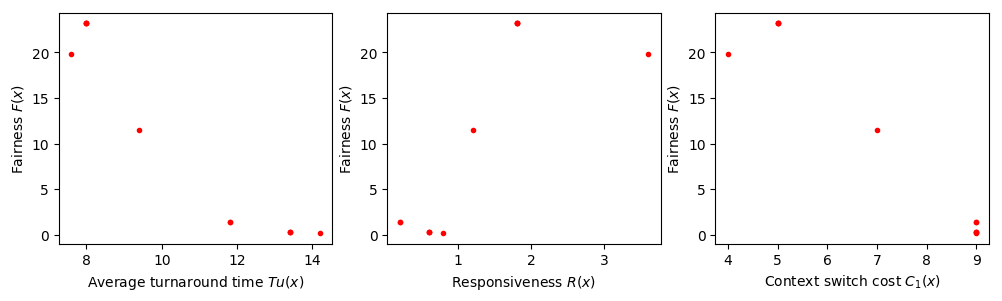

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only


In [8]:
# Define input data
num_tasks = 5                      # Number of tasks
A = [1, 2, 4, 6, 8]                # Arrival time of each task
D = [3, 6, 4, 5, 2]                # Duration of each task
max_time = minimum(A) + sum(D) + 2 # Time period considered
psi_1 = 0.4                        # Penalty of context switch
lambda_1 = 0.01                       # Tradeoff coefficient for Fairness F(x)
lambda_2 = 1                       # Tradeoff coefficient for Responsiveness R(x)
lambda_3 = 1                       # Tradeoff coefficient for context switch cost C1(x)


# Solve the model under different lambda_1 and save the results
num_samples = 12
Tus = []
Fs = []
Rs = []
C1s = []
for i = 1:num_samples
    result = model1(num_tasks, A, D, max_time, psi_1, lambda_1, lambda_2, lambda_3)
    append!(Tus, result[3])
    append!(Fs, result[4])
    append!(Rs, result[5])
    append!(C1s, result[6])
    lambda_1 *=2                 # linear incrase of lambda_1
end

using PyPlot
# Plot the figures
fig = figure(figsize=(12,3))
title("Under different \$\lambda_1\$:")
subplot(1,3,1)
xlabel("Average turnaround time \$Tu(x)\$")
ylabel("Fairness \$F(x)\$")
plot(Tus, Fs, "r.")
subplot(1,3,2)
xlabel("Responsiveness \$R(x)\$")
ylabel("Fairness \$F(x)\$")
plot(Rs, Fs, "r.")
subplot(1,3,3)
xlabel("Context switch cost \$C_1(x)\$")
ylabel("Fairness \$F(x)\$")
plot(C1s, Fs, "r.")
print()

- **Changing $\lambda_2$, i.e., the coefficient of responsiveness $R(x)$**

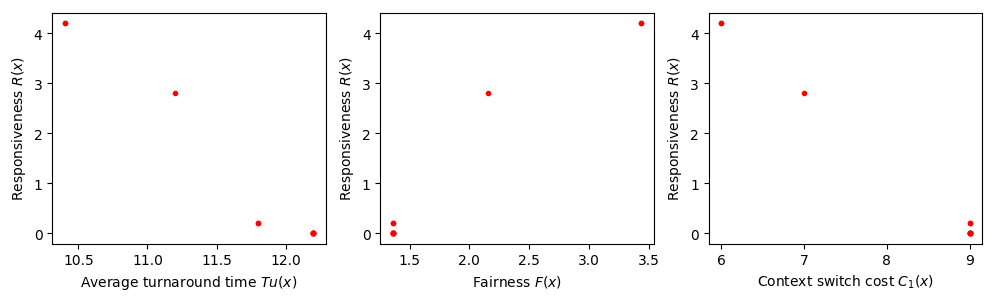

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only


In [6]:
# Define input data
num_tasks = 5                      # Number of tasks
A = [1, 2, 4, 6, 8]                # Arrival time of each task
D = [3, 6, 4, 5, 2]                # Duration of each task
max_time = minimum(A) + sum(D) + 2 # Time period considered
psi_1 = 0.4                        # Penalty of context switch
lambda_1 = 1                       # Tradeoff coefficient for Fairness F(x)
lambda_2 = 0.1                       # Tradeoff coefficient for Responsiveness R(x)
lambda_3 = 1                       # Tradeoff coefficient for context switch cost C1(x)


# Solve the model under different lambda_2 and save the results
num_samples = 12
Tus = []
Fs = []
Rs = []
C1s = []
for i = 1:num_samples
    result = model1(num_tasks, A, D, max_time, psi_1, lambda_1, lambda_2, lambda_3)
    append!(Tus, result[3])
    append!(Fs, result[4])
    append!(Rs, result[5])
    append!(C1s, result[6])
    lambda_2 *= 2                 # linear incrase of lambda_2
end

using PyPlot
# Plot the figures
fig = figure(figsize=(12,3))
title("Under different \$\lambda_2\$:")
subplot(1,3,1)
xlabel("Average turnaround time \$Tu(x)\$")
ylabel("Responsiveness \$R(x)\$")
plot(Tus, Rs, "r.")
subplot(1,3,2)
xlabel("Fairness \$F(x)\$")
ylabel("Responsiveness \$R(x)\$")
plot(Fs, Rs, "r.")
subplot(1,3,3)
xlabel("Context switch cost \$C_1(x)\$")
ylabel("Responsiveness \$R(x)\$")
plot(C1s, Rs, "r.")
print()

- **Changing $\lambda_3$, i.e., the coefficient of context switch cost $C_1(x)$**

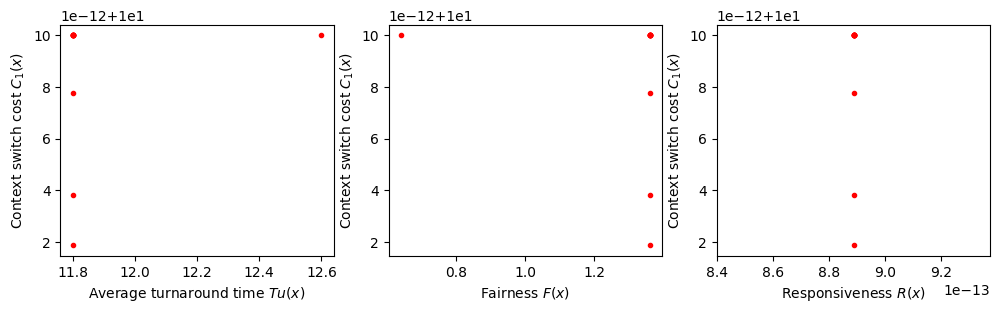

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only


In [10]:
# Define input data
num_tasks = 5                      # Number of tasks
A = [1, 2, 4, 6, 8]                # Arrival time of each task
D = [3, 6, 4, 5, 2]                # Duration of each task
max_time = minimum(A) + sum(D) + 2 # Time period considered
psi_1 = 0.4                        # Penalty of context switch
lambda_1 = 1                       # Tradeoff coefficient for Fairness F(x)
lambda_2 = 1                       # Tradeoff coefficient for Responsiveness R(x)
lambda_3 = 0.1                       # Tradeoff coefficient for context switch cost C1(x)


# Solve the model under different lambda_2 and save the results
num_samples = 12
Tus = []
Fs = []
Rs = []
C1s = []
for i = 1:num_samples
    result = model1(num_tasks, A, D, max_time, psi_1, lambda_1, lambda_2, lambda_3)
    append!(Tus, result[3])
    append!(Fs, result[4])
    append!(Rs, result[5])
    append!(C1s, result[6])
    lambda_2 *= 2                 # linear incrase of lambda_2
end

using PyPlot
# Plot the figures
fig = figure(figsize=(12,3))
title("Under different \$\lambda_3\$:")
subplot(1,3,1)
xlabel("Average turnaround time \$Tu(x)\$")
ylabel("Context switch cost \$C_1(x)\$")
plot(Tus, C1s, "r.")
subplot(1,3,2)
xlabel("Fairness \$F(x)\$")
ylabel("Context switch cost \$C_1(x)\$")
plot(Fs, C1s, "r.")
subplot(1,3,3)
xlabel("Responsiveness \$R(x)\$")
ylabel("Context switch cost \$C_1(x)\$")
plot(Rs, C1s, "r.")
print()

#### Analysis
The objective consists of 4 parts: average turnaround time $Tu(x)$, fairness $F(x)$, and responsiveness $R(x)$. Due to the nature of integer programming, the points cannot be strictly on a certain curve. That being said, there are still some relations that can be discovered.   

When we fix other coefficients and change $\lambda_1$, it is obvious that fairness $F(x)$ and average turnaround time $Tu(x)$ cannot be both optimized, so there has to be tradeoff between them. This can be empirically explained by that, fairness requires equal opportunity for the tasks to be executed, which inevitably increases the need for switching to other waiting tasks, rather than allowing the current task to finish as soon as possible.
  
It can also be found, by fixing either fairness $F(x)$ or responsiveness $R(x)$, that they are positively related. The more responsive, i.e., lower $R(x)$, the less waiting for the first execution. Since fairness is expressed as the variance of waiting time, it will also be lower, which explains such a positive relation.  

With more responsiveness (smaller $R(x)$), we can observe larger average turnaround time $Tu(x)$. This is mainly because, in order to respond to new tasks, the current one has to be postponed, which eventually result in a larger turnaround time.

In terms of context switch cost, it does not show apparent relations with any other components of the objective. This is no surprise because context switch cost is not modeled as part of the $x$ matrix, hence has no impact on other components that depend on the $x$ matrix. 

## 5. Conclusion ##

In this project, we try to model a complex problem --- process scheduling on multi-core CPU. We make some generalization to the model due to several facts, e.g. I/O-bound process can be seen as a CPU-bound process with small piece of CPU burst. We start from a stage where we assume that the CPU has perfect information about each coming process, i.e. when it will come and it duration. Then we add complexity by considering multi-core, process dependency. To deal with uncertainty, we make use of robust programming and stochastic programming.

By comparing the schedules our model finds using different objective orders to extant standalone scheduling algorithm, we find they are mostly consistent, which implies the feasibility of our model.

In sensitivity analysis, ... ... [TODO]

Due to the limited time, our model does have something to improve and we'd like to working on that in the future. In reality, CPU will schedule processes in a dynamic real-time manner, what we did is giving the scheduler a relative long time period so that all processes can be finished in this time interval. A more realistic and optimal modeling is to take out a time interval $[a, b]$ and give a bunch of processes(process stream). The scheduler should schedule some processes to run in this time interval so that the throughput and other objectives should be mostly optimal. Since some of our objectives depends on the finish time of each process, if a process may not be finished during this time interval, [TODO]

## 6. Reference ##

1. Operating Systems, Wikipedia, refer to https://en.wikipedia.org/wiki/Operating_system
2. Time-sharing, Wikipedia, refer to https://en.wikipedia.org/wiki/Time-sharing
3. History of CPU process scheduling, refer to http://dave-reed.com/csc539.S05/Lectures/CPUsched.ppt
4. Context Switch, Wikipedia, refer to https://en.wikipedia.org/wiki/Context_switch#Cost
5.  http://web.stanford.edu/class/ee364a/lectures/stoch_prog.pdf
6. Process scheduling under uncertainty: Review and challenges. Zukui Li, Marianthi Ierapetritou. Science Direct, Computers and Chemical Engineering 32 (2008) 715–727.
7. Round Robin Scheduling Algorithm, Wikipedia, refer to https://en.wikipedia.org/wiki/Round-robin_scheduling
8. Shortest Job First Scheduling, Techopedia, refer to https://www.techopedia.com/definition/22053/shortest-job-first-sjf
9. Multilevel Feedback Queue Algorithm, Wikipedia, refer to https://en.wikipedia.org/wiki/Multilevel_feedback_queue

## 7. Bonus! Have Fun Here!

You can select among several buttons to emphasize different aspects. See the different scheduling figure and results. Have fun!

Interact.Options{:ToggleButtons,Any}(65: "input-18" = (10, 1, 1) Any , "emphasize", (10, 1, 1), "fairness", 0, Interact.OptionDict(DataStructures.OrderedDict{Any,Any}("fairness"=>(10, 1, 1),"responsiveness"=>(1, 10, 1),"turnaround_time"=>(0.01, 0.01, 0.01),"all"=>(0.8, 0.7, 1)), Dict{Any,Any}(Pair{Any,Any}((0.8, 0.7, 1), "all"),Pair{Any,Any}((0.01, 0.01, 0.01), "turnaround_time"),Pair{Any,Any}((10, 1, 1), "fairness"),Pair{Any,Any}((1, 10, 1), "responsiveness"))), Any[], Any[], true, "horizontal")

Emphasize fairness:
Academic license - for non-commercial use only
Turnaround time T(x): 13.4000
Fairness F(x): 0.2400
Responsiveness R(x): 0.6000
Context switch cost C1(x): 9.0000


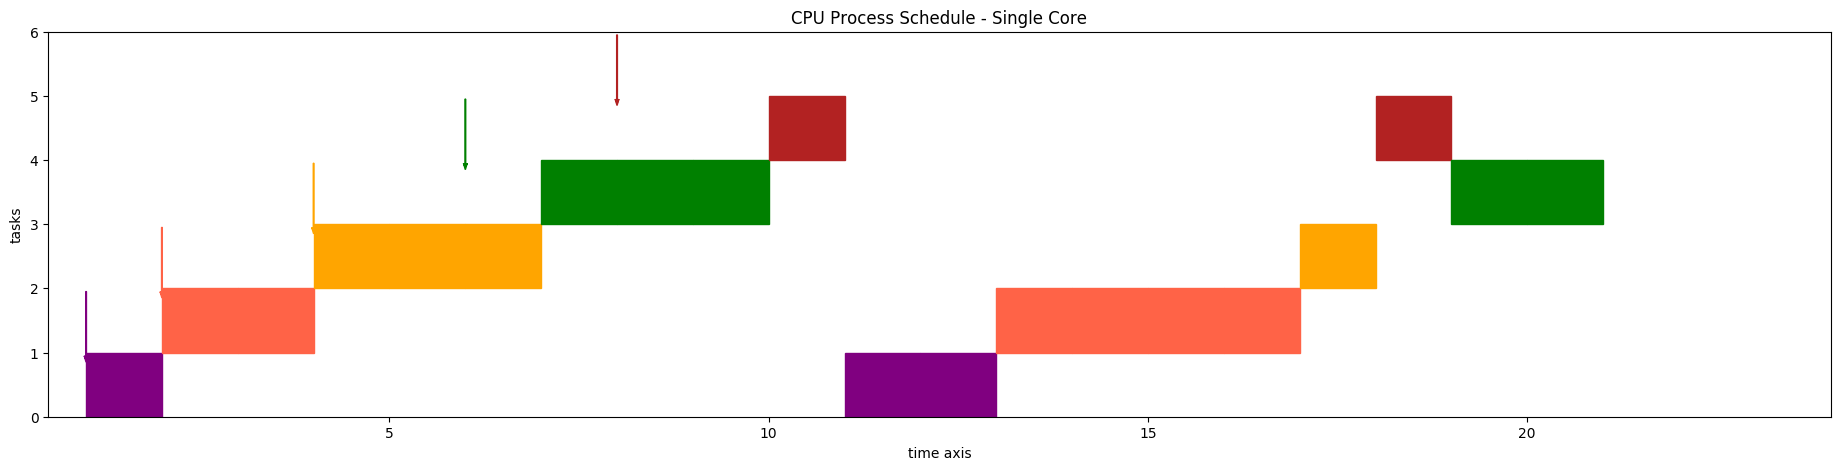

Emphasize responsiveness: 
Academic license - for non-commercial use only
Turnaround time T(x): 12.2000
Fairness F(x): 1.3600
Responsiveness R(x): 0.0000
Context switch cost C1(x): 9.0000


In [212]:
using Interact

# Define input data
num_tasks = 5                      # Number of tasks
A = [1, 2, 4, 6, 8]                # Arrival time of each task
D = [3, 6, 4, 5, 2]                # Duration of each task
max_time = minimum(A) + sum(D) + 2 # Time period considered
psi_1 = 0.4                        # Penalty of context switch

f = figure(figsize=(max_time, num_tasks))
@manipulate for emphasize=[:fairness => (10,1,1), :responsiveness => (1,10,1), :turnaround_time => (0.01,0.01,0.01), :all =>(0.8,0.7,1)]
    withfig(f) do 
    (lambda_1, lambda_2, lambda_3) = emphasize;
    if emphasize == (10,1,1)
        println("Emphasize fairness:")
    elseif emphasize == (1,10,1)
        println("Emphasize responsiveness: ")
    elseif emphasize == (0.01,0.01,0.01)
        println("Emphasize turnaround time: ")
    else
        println("No emphasize: ")
    end
    (status, x, Tu, Fa, R, C1, E, W, F) = model1(num_tasks, A, D, max_time, psi_1, lambda_1, lambda_2, lambda_3)
    # plot_schedule_1(x, A)
    xlim([0.5, max_time+1])
    ylim([0, num_tasks+1])
    xlabel("time axis") 
    ylabel("tasks")
    title("CPU Process Schedule - Single Core")

    colors = ["purple", "tomato", "orange", "green", "firebrick"]

    count = 0
    for p in A
        arrow(p, count+2, 0, -1, head_width=0.05, width=0.01, head_length=0.1, overhang=0.5, head_starts_at_zero="true", color=colors[count+1])
        count += 1
    end

    for t in 1 : max_time
        for p in 1 : num_tasks
            if x[p, t] > 0.9
                fill([t, t+1, t+1, t], [p-1, p-1, p, p], color = colors[p]);
            end
        end
    end
    @printf("Turnaround time T(x): %.4f\n", Tu)
    @printf("Fairness F(x): %.4f\n", Fa)
    @printf("Responsiveness R(x): %.4f\n", R)
    @printf("Context switch cost C1(x): %.4f\n", C1)
end
end